In [1]:
import numpy as np


# Very slow for many datapoints.  Fastest for many costs, most readable
def is_pareto_efficient_dumb(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

In [4]:
import sys 
import os 
from pathlib import Path 
import numpy as np 
import joblib

%load_ext autoreload
%autoreload 2

import pandas as pd
import shap 
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 
%matplotlib inline 

import seaborn as sns
plt.rcParams['font.family'] = 'sans-serif'

DATADIR = '../data'
TRAIN_SIZE = 0.7


import sys 
sys.path.append('../')
from dispersant_screener.definitions import FEATURES
from dispersant_screener.utils import plot_parity


import wandb
from lightgbm import LGBMRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
df_full_factorial_feat = pd.read_csv(os.path.join(DATADIR, 'new_features_full_random.csv')).values
a2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
deltaGMax = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['A2_normalized'].values
gibbs = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_deltaG.csv'))['deltaGmin'].values
gibbs_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_new.csv'))['deltaGmax'].values
force_max = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large_fit2.csv'))['F_repel_max'].values
rg = pd.read_csv(os.path.join(DATADIR, 'rg_results.csv'))['Rg'].values
y = np.hstack([
    rg.reshape(-1, 1),
    -1* gibbs.reshape(-1, 1),
    gibbs_max.reshape(-1, 1),
])
assert len(df_full_factorial_feat) == len(a2) == len(gibbs) == len(y)

In [6]:
indices = is_pareto_efficient_dumb(-y)

In [7]:
sum(indices)

45


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


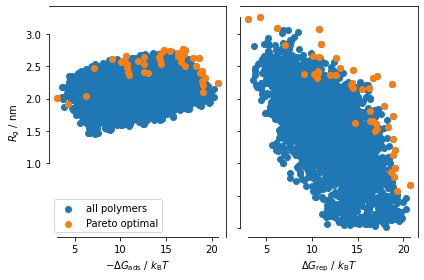

In [8]:
fig, ax = plt.subplots(1,2, sharey=True)

ax[0].scatter(y[:,1], y[:,0], label='all polymers')
ax[0].scatter(y[indices,1], y[indices,0], label='Pareto optimal')

ax[1].scatter(y[:,1], y[:,2], label='all polymers')
ax[1].scatter(y[indices,1], y[indices,2], label='Pareto optimal')

for a in ax:
    a.spines['left'].set_smart_bounds(True)
    a.spines['bottom'].set_smart_bounds(True)

ax[0].set_xlabel('$-\Delta G_\mathrm{ads}$ / $k_\mathrm{B}T$')
ax[0].set_ylabel('$R_\mathrm{g}$ / nm')
ax[1].set_xlabel('$\Delta G_\mathrm{rep}$ / $k_\mathrm{B}T$')

ax[0].legend(loc='lower left')

fig.tight_layout()

fig.savefig('design_space.pdf', bbox_inches='tight')

In [9]:
from sklearn.decomposition import PCA

In [10]:
X = StandardScaler().fit_transform(df_full_factorial_feat)

In [11]:
pca = PCA(2)

In [12]:
X_pca = pca.fit_transform(X)


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


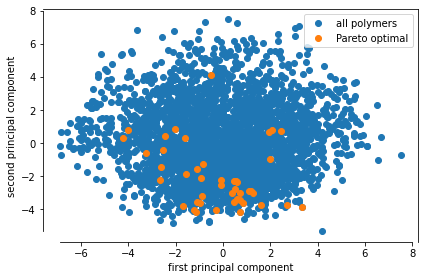

In [13]:
fig, ax = plt.subplots(1,1)
ax.scatter(X_pca[:,0], X_pca[:,1], label='all polymers')
ax.scatter(X_pca[indices,0], X_pca[indices,1], label='Pareto optimal')

ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)


ax.set_xlabel('first principal component')
ax.set_ylabel('second principal component')
ax.legend()

fig.tight_layout()

fig.savefig('pca.pdf', bbox_inches='tight')

In [14]:
import umap

In [15]:
reducer = umap.UMAP()

In [16]:
embedding = reducer.fit_transform(X)


The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.

The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.


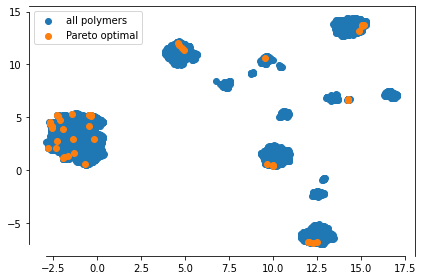

In [17]:
fig, ax = plt.subplots(1,1)
ax.scatter(embedding[:,0], embedding[:,1], label='all polymers')
ax.scatter(embedding[indices,0], embedding[indices,1], label='Pareto optimal')

ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

ax.legend()

fig.tight_layout()

fig.savefig('umap.pdf', bbox_inches='tight')